In [1]:
# cell 1 — imports, config, paths

import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)
pd.set_option("display.max_columns", 120)

def resolve(p):
    p = Path(p)
    if p.exists():
        return p
    alt = Path("/mnt/data") / p.name
    return alt if alt.exists() else p

TRAIN_PATH   = resolve("project_adult.csv")
HOLDOUT_PATH = resolve("project_validation_inputs.csv")


In [2]:
# cell 2 — load + basic hygiene

df      = pd.read_csv(TRAIN_PATH)
df_hold = pd.read_csv(HOLDOUT_PATH)

for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip()
for c in df_hold.select_dtypes(include=["object"]).columns:
    df_hold[c] = df_hold[c].astype(str).str.strip()

print("train shape:", df.shape, "| holdout shape:", df_hold.shape)
df.head(3)


train shape: (26048, 16) | holdout shape: (6513, 15)


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [3]:
# cell 3 — target mapping and feature frames

assert "income" in df.columns, "expected target column 'income' in train data"

label_map = {">50K": 1, "<=50K": -1, " >50K": 1, " <=50K": -1}
y = df["income"].map(label_map)
assert y.notna().all(), "target mapping produced nulls; check label strings"

X = df.drop(columns=["income"]).copy()
Z = df_hold.copy()

print("class counts (mapped):\n", y.value_counts().rename(index={-1:"<=50K", 1:">50K"}))
print("minority share (>50K):", float((y==1).mean()))

class counts (mapped):
 income
<=50K    19778
>50K      6270
Name: count, dtype: int64
minority share (>50K): 0.24070945945945946


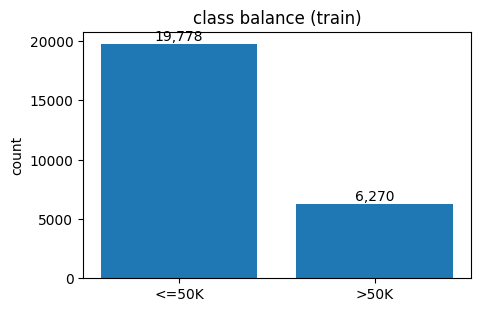

In [4]:
# cell 4 — class balance viz

cls_counts = y.value_counts().sort_index()
labels = ["<=50K", ">50K"]
values = [int(cls_counts.loc[-1]), int(cls_counts.loc[1])]

plt.figure(figsize=(5,3.2))
plt.bar(labels, values)
plt.title("class balance (train)")
plt.ylabel("count")
for i,v in enumerate(values):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")
plt.show()

In [5]:
# cell 5 — schema discovery + guards

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("n numeric:", len(num_cols), "| n categorical:", len(cat_cols))
print("num_cols (head):", num_cols[:6])
print("cat_cols (head):", cat_cols[:6])

missing_in_holdout = [c for c in X.columns if c not in Z.columns]
assert not missing_in_holdout, f"holdout missing expected feature(s): {missing_in_holdout}"


n numeric: 7 | n categorical: 8
num_cols (head): ['Unnamed: 0', 'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
cat_cols (head): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']


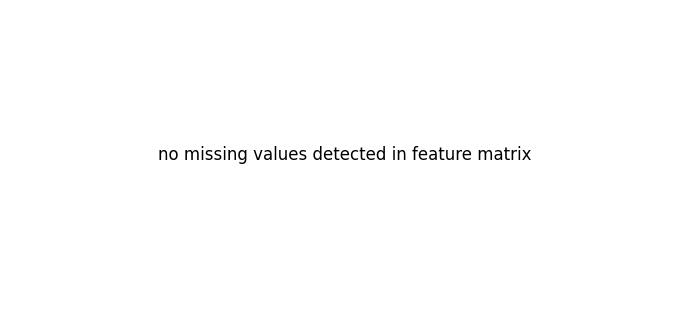

In [6]:
# cell 6 — missingness profile (robust to 'no missing' case)

miss_pct = (X.isna().mean()*100).sort_values(ascending=False)

plt.figure(figsize=(7,3.2))
if (miss_pct > 0).any():
    top = miss_pct[miss_pct>0].head(12)
    plt.bar(top.index, top.values)
    plt.title("missing values by column (%) — top nonzero")
    plt.ylabel("% missing")
    plt.xticks(rotation=45, ha="right")
    for i,v in enumerate(top.values):
        plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
else:
    plt.axis("off")
    plt.text(0.5, 0.5, "no missing values detected in feature matrix",
             ha="center", va="center", fontsize=12)
plt.tight_layout()
plt.show()


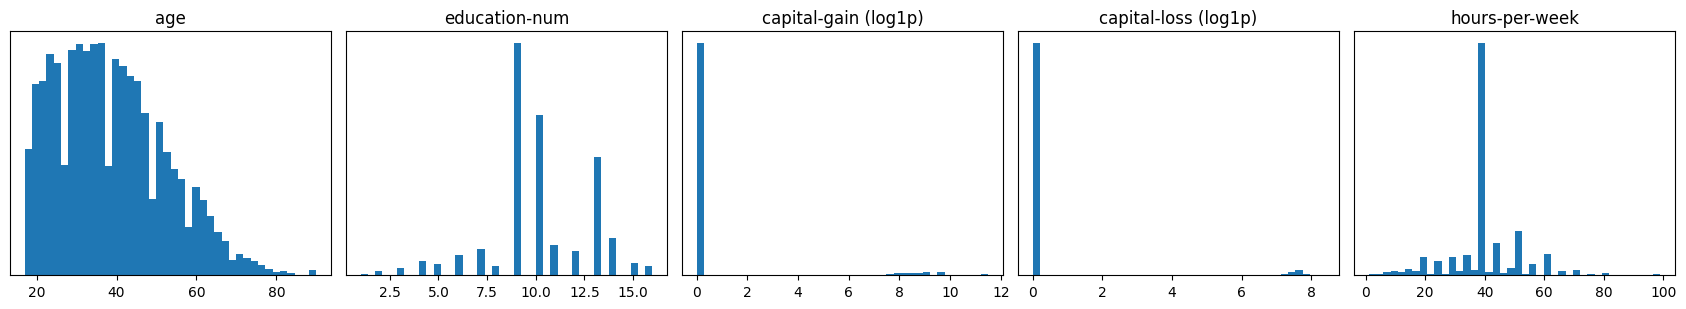

In [7]:
# cell 7 — numeric dist viz (key columns)

num_preview = [c for c in ["age","education-num","capital-gain","capital-loss","hours-per-week"] if c in num_cols]
n = len(num_preview)
if n:
    plt.figure(figsize=(1+3.2*n, 3.2))
    for i,c in enumerate(num_preview, 1):
        plt.subplot(1, n, i)
        vals = np.asarray(X[c].dropna())
        if c in ["capital-gain","capital-loss"]:
            vals = np.log1p(vals)
            plt.hist(vals, bins=40)
            plt.title(f"{c} (log1p)")
        else:
            plt.hist(vals, bins=40)
            plt.title(c)
        plt.yticks([])
    plt.tight_layout()
    plt.show()


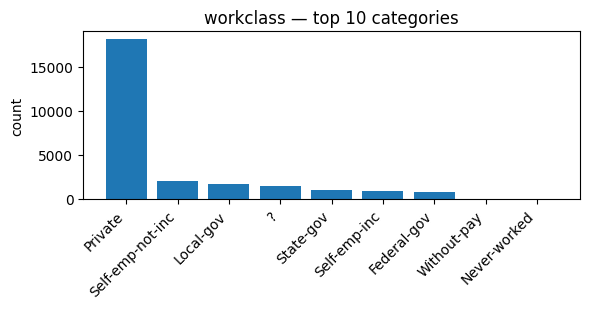

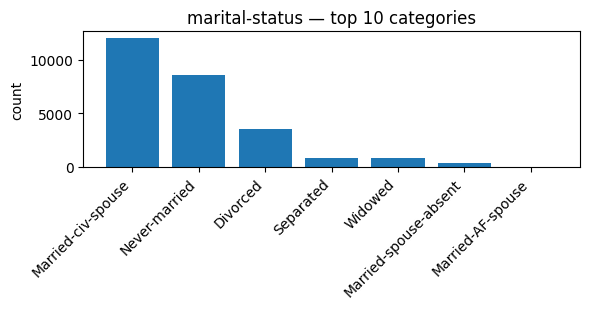

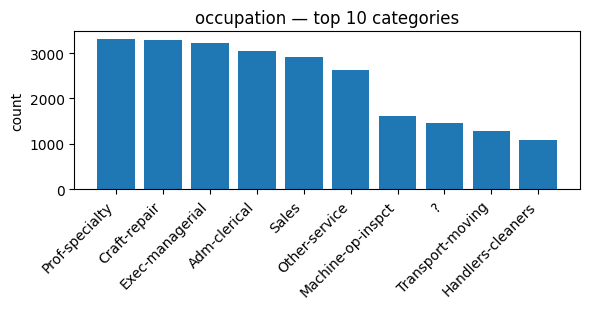

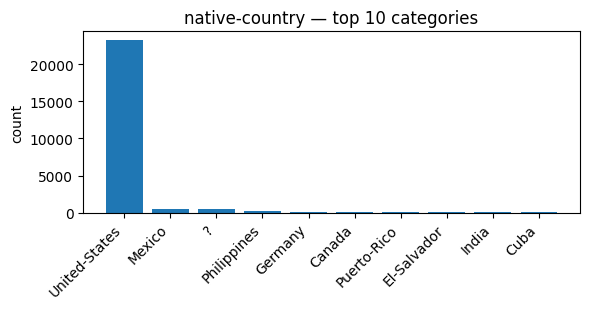

In [8]:
# cell 8 — top categories viz

cat_preview = [c for c in ["workclass","marital-status","occupation","native-country"] if c in cat_cols][:4]
for c in cat_preview:
    vc = X[c].value_counts().head(10)
    plt.figure(figsize=(6,3.2))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"{c} — top 10 categories")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [9]:
# cell 9 — preprocessing pipeline (median/mode + scaling + one-hot)

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=True, with_std=True)),
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    # sklearn >=1.4 uses 'sparse_output' (not 'sparse')
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

print("preprocessing pipeline constructed")


preprocessing pipeline constructed


shapes — transformed:
  train: (20838, 108) | valid: (5210, 108) | holdout: (6513, 108)
{'post_transform_nans': {'train': 0, 'valid': 0, 'holdout': 0}}


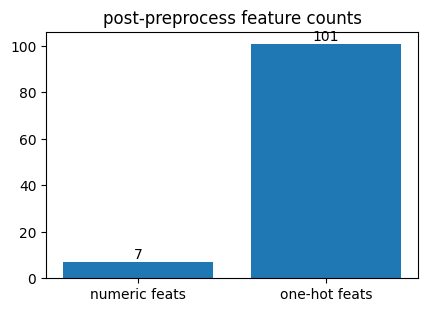

In [10]:
# cell 10 — local dev split + smoke test transform

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

pre.fit(X_tr)
X_tr_p = pre.transform(X_tr)
X_va_p = pre.transform(X_va)
Z_p    = pre.transform(Z)

print("shapes — transformed:")
print("  train:", X_tr_p.shape, "| valid:", X_va_p.shape, "| holdout:", Z_p.shape)

def _nan_count(mat):
    if hasattr(mat, "toarray"):
        a = mat.toarray()
    else:
        a = mat
    return int(np.isnan(a).sum())

print({
    "post_transform_nans": {
        "train": _nan_count(X_tr_p),
        "valid": _nan_count(X_va_p),
        "holdout": _nan_count(Z_p),
    }
})

try:
    feat_names = pre.get_feature_names_out()
    n_num = sum(name.startswith("num__") for name in feat_names)
    n_cat = sum(name.startswith("cat__") for name in feat_names)
    plt.figure(figsize=(4.8,3.2))
    plt.bar(["numeric feats","one-hot feats"], [n_num, n_cat])
    plt.title("post-preprocess feature counts")
    for i,v in enumerate([n_num, n_cat]):
        plt.text(i, v, f"{v}", ha="center", va="bottom")
    plt.show()
except Exception as e:
    print("feature names not available:", e)


In [11]:
# cell 11 — mlp pipeline scaffold (early stopping + sane defaults)
# build a stable baseline network and keep preprocessing inside the pipeline (prevents leakage)

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

mlp_base = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # two hidden layers with moderate width
    activation="relu",              # common choice for tabular + works with adam
    solver="adam",                  # mini-batch optimizer
    alpha=1e-4,                     # L2 regularization
    batch_size=128,                 # batch size for adam
    learning_rate_init=1e-3,        # initial step size
    max_iter=400,                   # upper bound; early stopping will stop earlier
    early_stopping=True,            # monitor internal validation split
    n_iter_no_change=10,            # patience for early stopping
    validation_fraction=0.1,        # internal validation fraction from training fold
    random_state=SEED,              # reproducibility
    shuffle=True,                   # shuffle samples each epoch
    verbose=False,                  # turn on if you want epoch logs
)

pipe = Pipeline(steps=[
    ("pre", pre),   # columntransformer from part a (impute+scale+onehot)
    ("clf", mlp_base)
])

print(pipe)  # verify the pipeline structure


Pipeline(steps=[('pre',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'age',
                                                   'fnlwgt', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                              

In [12]:
# cell 12 — make a balanced train split (minority upsampling)
# create a balanced copy of (X_tr, y_tr) to mitigate class imbalance for the fit

from collections import Counter

def upsample_minority(X_df, y_ser, random_state=SEED):
    tmp = X_df.copy()
    tmp["_y"] = y_ser.values

    counts = Counter(y_ser)
    maj_cls = max(counts, key=counts.get)
    min_cls = min(counts, key=counts.get)

    n_maj = counts[maj_cls]
    df_maj = tmp[tmp["_y"] == maj_cls]
    df_min = tmp[tmp["_y"] == min_cls]

    # upsample minority to match majority count (with replacement)
    df_min_up = df_min.sample(n=n_maj, replace=True, random_state=random_state)
    # shuffle to remove ordering bias
    df_bal = pd.concat([df_maj, df_min_up], axis=0).sample(frac=1.0, random_state=random_state)

    X_bal = df_bal.drop(columns=["_y"])
    y_bal = df_bal["_y"].astype(int)
    return X_bal, y_bal

X_tr_bal, y_tr_bal = upsample_minority(X_tr, y_tr)
print("class counts (train original):", Counter(y_tr))
print("class counts (train balanced):", Counter(y_tr_bal))
print("balanced shapes:", X_tr_bal.shape, y_tr_bal.shape)


class counts (train original): Counter({-1: 15822, 1: 5016})
class counts (train balanced): Counter({-1: 15822, 1: 15822})
balanced shapes: (31644, 15) (31644,)


In [13]:
# cell 13 — probe fit on balanced train + dev metrics
# quick sanity check of model behavior on dev split

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# fit on the balanced training copy; preprocessing occurs inside the pipeline
_ = pipe.fit(X_tr_bal, y_tr_bal)

# predictions on dev split
y_va_pred  = pipe.predict(X_va)                  # hard labels using default threshold 0.5
y_va_proba = pipe.predict_proba(X_va)[:, 1]      # class-1 probabilities for curves

# metrics
acc = accuracy_score(y_va, y_va_pred)
cm  = confusion_matrix(y_va, y_va_pred, labels=[-1, 1])
fpr, tpr, _ = roc_curve(y_va, y_va_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

print({"dev_accuracy": round(acc, 4), "roc_auc": round(roc_auc, 4)})
print("confusion matrix (rows=true, cols=pred):\n", cm)


{'dev_accuracy': 0.8159, 'roc_auc': 0.8718}
confusion matrix (rows=true, cols=pred):
 [[3418  538]
 [ 421  833]]


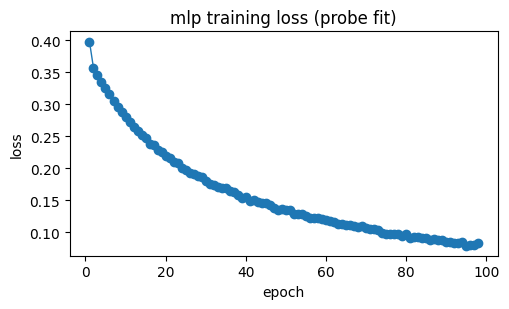

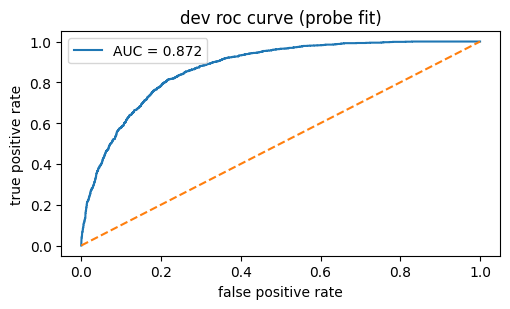

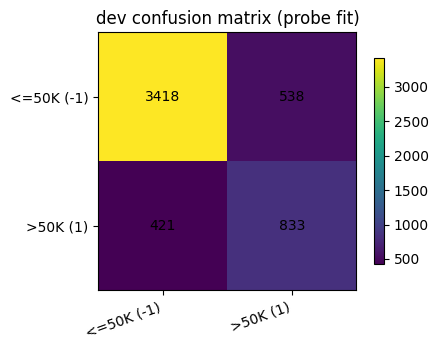

In [14]:
# cell 14 — visuals from the probe fit: loss curve, ROC, confusion matrix
# figures are presentation-ready; no style changes needed downstream

# training loss curve extracted from the final fitted MLP
loss_curve = pipe.named_steps["clf"].loss_curve_

plt.figure(figsize=(5.2,3.2))
plt.plot(range(1, len(loss_curve)+1), loss_curve, marker="o", linewidth=1)
plt.title("mlp training loss (probe fit)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.tight_layout(); plt.show()

# roc curve on dev
plt.figure(figsize=(5.2,3.2))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("dev roc curve (probe fit)")
plt.xlabel("false positive rate"); plt.ylabel("true positive rate")
plt.legend(); plt.tight_layout(); plt.show()

# confusion matrix heatmap
labels = ["<=50K (-1)", ">50K (1)"]
plt.figure(figsize=(4.6,3.6))
plt.imshow(cm)
plt.xticks([0,1], labels, rotation=20, ha="right")
plt.yticks([0,1], labels)
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center")
plt.title("dev confusion matrix (probe fit)")
plt.colorbar(shrink=0.8); plt.tight_layout(); plt.show()


In [15]:
# cell 15 — cross-validation search object (configured; not executing here)
# modest grid over key hyperparameters; refit uses accuracy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
try:
    from sklearn.experimental import enable_halving_search_cv  # noqa: F401
    from sklearn.model_selection import HalvingGridSearchCV
    use_halving = True
except Exception:
    use_halving = False

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "clf__hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "clf__alpha": [1e-5, 1e-4, 1e-3],
    "clf__batch_size": [64, 128],
    "clf__learning_rate_init": [1e-3, 5e-4],
    "clf__activation": ["relu", "tanh"],
}

if use_halving:
    search = HalvingGridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        factor=2,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True,
        random_state=SEED
    )
else:
    search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True,
        return_train_score=True
    )

print("cv search object ready:", type(search).__name__)


cv search object ready: HalvingGridSearchCV


In [16]:
# cell 16 — helper to run CV later + plot top configs (not executed)
# when ready, call: best_search, top = run_cv_and_plot(search, X, y)

def run_cv_and_plot(search_obj, X_all, y_all):
    search_obj.fit(X_all, y_all)

    print("best params:", search_obj.best_params_)
    print("best score (accuracy):", round(search_obj.best_score_, 4))

    res = pd.DataFrame(search_obj.cv_results_)
    cols = ["param_clf__hidden_layer_sizes","param_clf__alpha",
            "param_clf__batch_size","param_clf__learning_rate_init",
            "param_clf__activation","mean_test_score"]
    have = [c for c in cols if c in res.columns]
    table = res[have].sort_values("mean_test_score", ascending=False).head(12)
    
    plt.figure(figsize=(8,3.6))
    plt.barh(range(len(table)), table["mean_test_score"])
    plt.yticks(range(len(table)), [str(tuple(row[:5])) for row in table.iloc[:, :5].values])
    plt.xlabel("cv accuracy"); plt.title("top cv configs")
    plt.gca().invert_yaxis()
    plt.tight_layout(); plt.show()

    return search_obj, table

print("helper defined: run_cv_and_plot(search, X, y)")


helper defined: run_cv_and_plot(search, X, y)


In [17]:
# cell 17 — submission naming (for later export; no write in this step)
# final predictions will be written to this path in part 2

from pathlib import Path
SUBMISSION_NAME = "Group_14_MLP_PredictedOutputs.csv"
SUBMISSION_DIR  = Path("./submission")
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)
SUBMISSION_PATH = SUBMISSION_DIR / SUBMISSION_NAME

print("submission target:", SUBMISSION_PATH)


submission target: submission/Group_14_MLP_PredictedOutputs.csv


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 407
max_resources_: 26048
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 407
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 1
n_candidates: 36
n_resources: 814
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 18
n_resources: 1628
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 9
n_resources: 3256
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 5
n_resources: 6512
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 3
n_resources: 13024
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 26048
Fitting 5 folds for each of 2 candidates, totalling 10 fits
best params: {'clf__activation': 'tanh', 'clf__alpha'

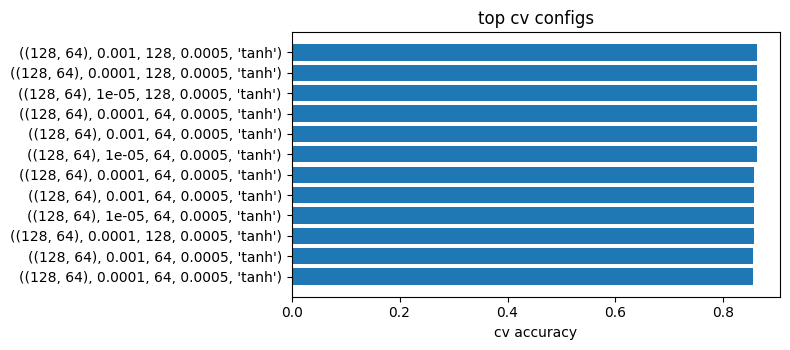

selected params: {'clf__activation': 'tanh', 'clf__alpha': 0.001, 'clf__batch_size': 64, 'clf__hidden_layer_sizes': (128, 64), 'clf__learning_rate_init': 0.0005}
cv accuracy (mean over folds): 0.8546


In [18]:
# cell 18 — run cross-validation on the modest grid and visualize top configs
# uses the search object from step b (cell 15) and helper from cell 16

# note: cv is executed on the original (X, y) without touching holdout.
# the ColumnTransformer lives inside the pipeline, so there’s no leakage.

best_search, top_table = run_cv_and_plot(search, X, y)

# capture best params for reuse
best_params = best_search.best_params_
best_score  = float(best_search.best_score_)
print("selected params:", best_params)
print("cv accuracy (mean over folds):", round(best_score, 4))


In [19]:
# cell 19 — rebuild the pipeline with the best hyperparameters from CV
# this ensures a minimal, explicit object for downstream use

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# unpack cv params safely; fall back to defaults if keys are not in grid
hls = best_params.get("clf__hidden_layer_sizes", (128, 64))
alp = best_params.get("clf__alpha", 1e-4)
bsz = best_params.get("clf__batch_size", 128)
lr0 = best_params.get("clf__learning_rate_init", 1e-3)
act = best_params.get("clf__activation", "relu")

mlp_best = MLPClassifier(
    hidden_layer_sizes=hls,
    activation=act,
    solver="adam",              # cv grid built around adam
    alpha=alp,
    batch_size=bsz,
    learning_rate_init=lr0,
    max_iter=400,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=SEED,
    shuffle=True,
    verbose=False,
)

pipe_best = Pipeline(steps=[
    ("pre", pre),               # same preprocessing as step a
    ("clf", mlp_best)
])

print(pipe_best)


Pipeline(steps=[('pre',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'age',
                                                   'fnlwgt', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                              

In [20]:
 # cell 20 — refit best model on the training split (balanced) and evaluate on dev
# keep a clean separation: fit on X_tr only, evaluate on X_va only

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import numpy as np

# create a balanced copy of the training portion
X_tr_bal, y_tr_bal = upsample_minority(X_tr, y_tr)

# fit the best pipeline
_ = pipe_best.fit(X_tr_bal, y_tr_bal)

# dev predictions (hard + probabilities)
y_va_pred  = pipe_best.predict(X_va)
y_va_proba = pipe_best.predict_proba(X_va)[:, 1]

# dev metrics at default 0.5 threshold
acc_05 = accuracy_score(y_va, y_va_pred)
cm_05  = confusion_matrix(y_va, y_va_pred, labels=[-1, 1])
fpr, tpr, _ = roc_curve(y_va, y_va_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

print({
    "dev_accuracy@0.50": round(acc_05, 4),
    "roc_auc": round(roc_auc, 4),
    "cv_mean_accuracy": round(best_score, 4)
})
print("confusion matrix @0.50 (rows=true, cols=pred):\n", cm_05)


{'dev_accuracy@0.50': 0.8211, 'roc_auc': 0.8806, 'cv_mean_accuracy': 0.8546}
confusion matrix @0.50 (rows=true, cols=pred):
 [[3419  537]
 [ 395  859]]


In [21]:
# cell 21 — tune the decision threshold on dev to maximize accuracy (for reporting)
# this does not change the submission format; stored threshold will be used later if desired

thr_grid = np.linspace(0.20, 0.80, 121)

def best_threshold(y_true, proba, grid):
    accs = []
    for t in grid:
        pred = np.where(proba >= t, 1, -1)
        accs.append(accuracy_score(y_true, pred))
    idx = int(np.argmax(accs))
    return float(grid[idx]), float(accs[idx]), np.array(accs)

T_STAR, ACC_STAR, ACC_CURVE = best_threshold(y_va, y_va_proba, thr_grid)

print({"dev_accuracy@t*": round(ACC_STAR, 4), "t*": round(T_STAR, 3)})


{'dev_accuracy@t*': 0.8311, 't*': 0.78}


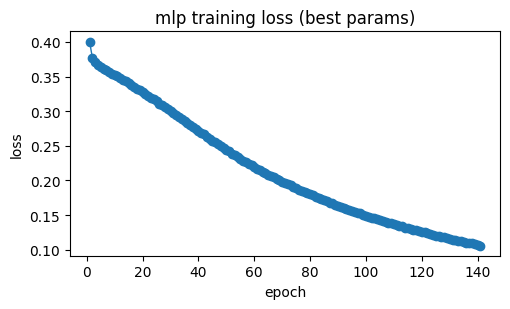

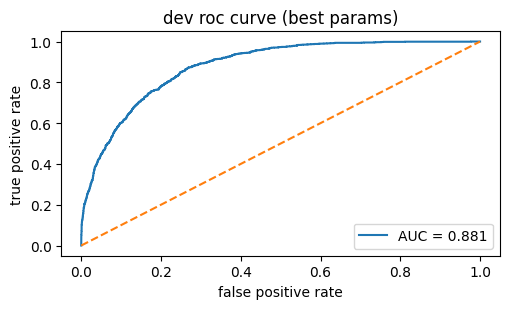

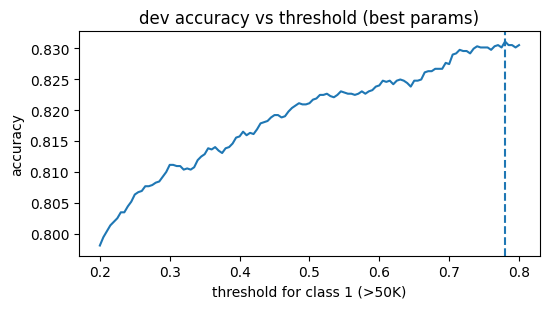

In [22]:
# cell 22 — quick visuals for the “best so far” model (training loss, roc, accuracy vs threshold)
# figures are presentation-ready

# training loss curve from the fitted best model
loss_curve = pipe_best.named_steps["clf"].loss_curve_
plt.figure(figsize=(5.2,3.2))
plt.plot(range(1, len(loss_curve)+1), loss_curve, marker="o", linewidth=1)
plt.title("mlp training loss (best params)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.tight_layout(); plt.show()

# roc on dev
plt.figure(figsize=(5.2,3.2))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("dev roc curve (best params)")
plt.xlabel("false positive rate"); plt.ylabel("true positive rate")
plt.legend(); plt.tight_layout(); plt.show()

# accuracy vs threshold
plt.figure(figsize=(5.6,3.2))
plt.plot(thr_grid, ACC_CURVE)
plt.axvline(T_STAR, linestyle="--")
plt.title("dev accuracy vs threshold (best params)")
plt.xlabel("threshold for class 1 (>50K)"); plt.ylabel("accuracy")
plt.tight_layout(); plt.show()


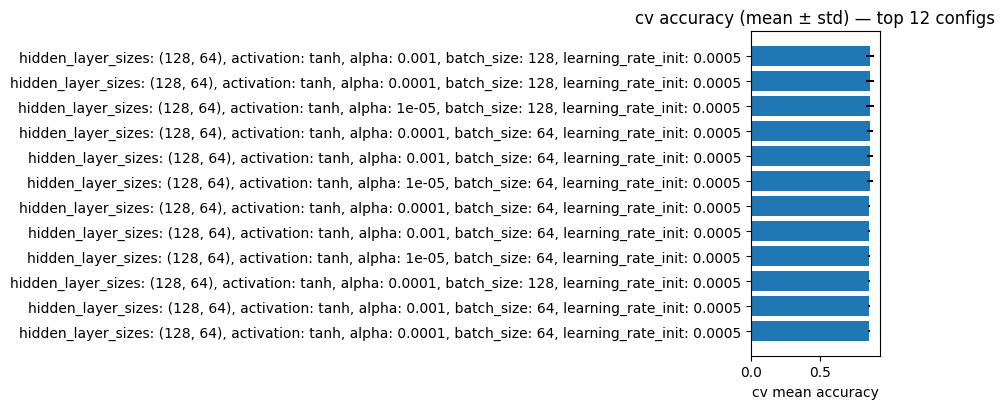

In [23]:
# cell 22a — cv summary: mean accuracy with variability (top 12 configs)
# uses best_search from step c; plots mean ± std across folds

res = pd.DataFrame(best_search.cv_results_).copy()

# compute std across folds if not present
if "std_test_score" not in res.columns:
    split_cols = [c for c in res.columns if c.startswith("split") and c.endswith("_test_score")]
    res["std_test_score"] = res[split_cols].std(axis=1)

# compact label for each config
def cfg_label(row):
    parts = []
    for k in ["param_clf__hidden_layer_sizes","param_clf__activation",
              "param_clf__alpha","param_clf__batch_size","param_clf__learning_rate_init"]:
        if k in row and not pd.isna(row[k]):
            parts.append(f"{k.replace('param_clf__','')}: {row[k]}")
    return ", ".join(parts)

res["label"] = res.apply(cfg_label, axis=1)

top = res.sort_values("mean_test_score", ascending=False).head(12).iloc[::-1]

plt.figure(figsize=(9,4.2))
plt.barh(range(len(top)), top["mean_test_score"], xerr=top["std_test_score"])
plt.yticks(range(len(top)), top["label"])
plt.xlabel("cv mean accuracy")
plt.title("cv accuracy (mean ± std) — top 12 configs")
plt.tight_layout()
plt.show()


/var/folders/fy/4nvfh3q55tn4yfm65rt6w8p40000gn/T/ipykernel_31510/2741886147.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, labels=labels, showmeans=True)


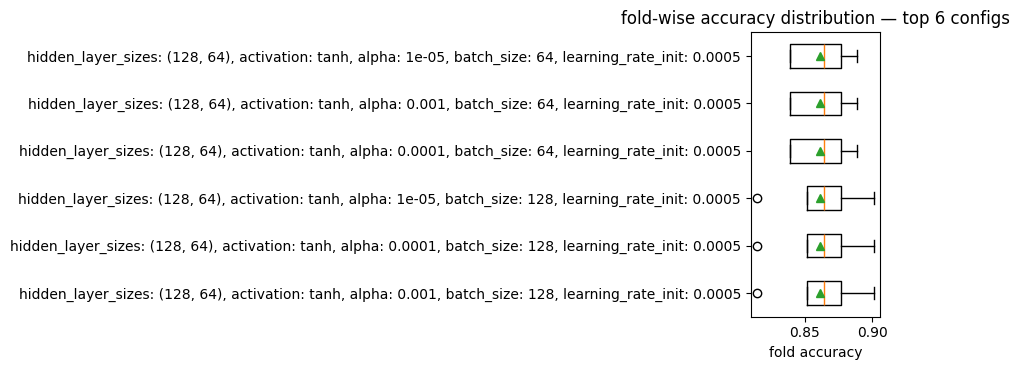

In [24]:
# cell 22b — fold-wise variance: boxplot of split accuracies for top 6 configs

split_cols = [c for c in res.columns if c.startswith("split") and c.endswith("_test_score")]
top6 = res.sort_values("mean_test_score", ascending=False).head(6).reset_index(drop=True)

data = [top6.loc[i, split_cols].values.astype(float) for i in range(len(top6))]
labels = [top6.loc[i, "label"] for i in range(len(top6))]

plt.figure(figsize=(9,3.8))
plt.boxplot(data, vert=False, labels=labels, showmeans=True)
plt.xlabel("fold accuracy")
plt.title("fold-wise accuracy distribution — top 6 configs")
plt.tight_layout()
plt.show()


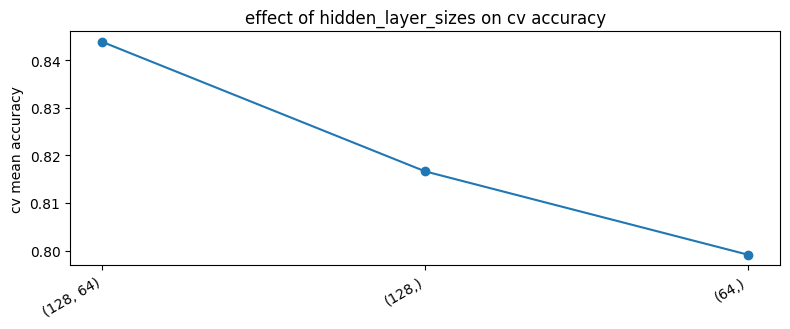

In [25]:
# cell 22c — architecture sweep: effect of hidden_layer_sizes on cv accuracy

def hls_str(x):
    return str(x) if isinstance(x, tuple) else str(tuple([int(x)]))

if "param_clf__hidden_layer_sizes" in res.columns:
    grp = (res.groupby(res["param_clf__hidden_layer_sizes"].map(hls_str))
             .agg(mean_acc=("mean_test_score","mean"),
                  std_acc=("mean_test_score","std"),
                  n=("mean_test_score","count"))
             .reset_index()
             .sort_values("mean_acc", ascending=False))

    plt.figure(figsize=(8,3.4))
    plt.plot(range(len(grp)), grp["mean_acc"], marker="o")
    plt.xticks(range(len(grp)), grp["param_clf__hidden_layer_sizes"], rotation=30, ha="right")
    plt.ylabel("cv mean accuracy")
    plt.title("effect of hidden_layer_sizes on cv accuracy")
    plt.tight_layout()
    plt.show()


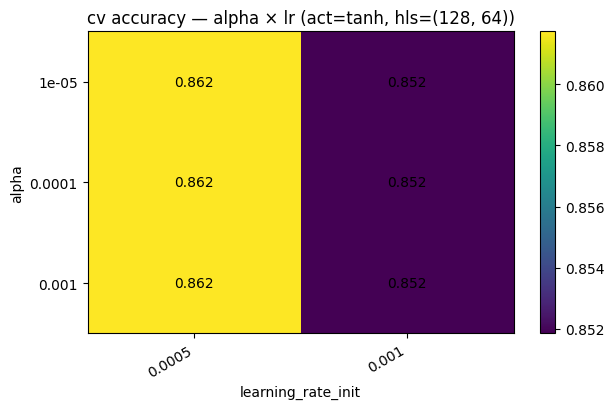

In [26]:
# cell 22d — interaction grid: alpha vs learning_rate_init at best activation + architecture

cols_needed = {"param_clf__alpha","param_clf__learning_rate_init",
               "param_clf__activation","param_clf__hidden_layer_sizes","mean_test_score"}
if cols_needed.issubset(res.columns):
    # pick the best-performing (activation, hls) pair
    best_row = res.sort_values("mean_test_score", ascending=False).iloc[0]
    act_best = best_row["param_clf__activation"]
    hls_best = best_row["param_clf__hidden_layer_sizes"]

    sub = res[(res["param_clf__activation"]==act_best) &
              (res["param_clf__hidden_layer_sizes"]==hls_best)]

    piv = sub.pivot_table(index="param_clf__alpha",
                          columns="param_clf__learning_rate_init",
                          values="mean_test_score", aggfunc="max").sort_index(axis=0).sort_index(axis=1)

    arr = piv.values.astype(float)
    plt.figure(figsize=(6.4,4.2))
    plt.imshow(arr, aspect="auto")
    plt.title(f"cv accuracy — alpha × lr (act={act_best}, hls={hls_best})")
    plt.ylabel("alpha"); plt.xlabel("learning_rate_init")
    plt.yticks(range(len(piv.index)), [f"{v:g}" for v in piv.index])
    plt.xticks(range(len(piv.columns)), [f"{v:g}" for v in piv.columns], rotation=30, ha="right")
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if not np.isnan(arr[i,j]):
                plt.text(j, i, f"{arr[i,j]:.3f}", ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [27]:
# cell 23 — lock artifacts for downstream use (no file writes here)
# keep best params, best pipeline, and the chosen dev threshold in variables

BEST_PARAMS   = best_params
BEST_PIPELINE = pipe_best
BEST_THR      = T_STAR

print("locked:")
print("  BEST_PARAMS:", BEST_PARAMS)
print("  BEST_THR:", round(BEST_THR, 3))


locked:
  BEST_PARAMS: {'clf__activation': 'tanh', 'clf__alpha': 0.001, 'clf__batch_size': 64, 'clf__hidden_layer_sizes': (128, 64), 'clf__learning_rate_init': 0.0005}
  BEST_THR: 0.78


{'cv_mean_accuracy': 0.8546, 'dev_acc@0.50': 0.8211, 'dev_acc@t*': 0.8311, 't*': 0.78, 'dev_auc': 0.8806}


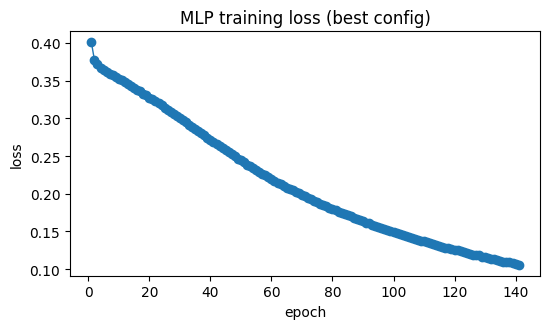

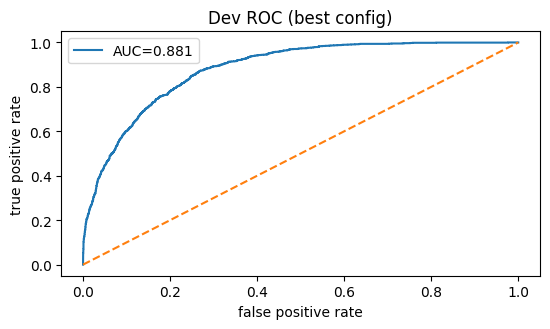

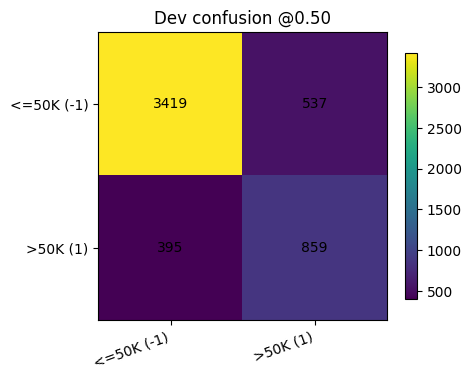

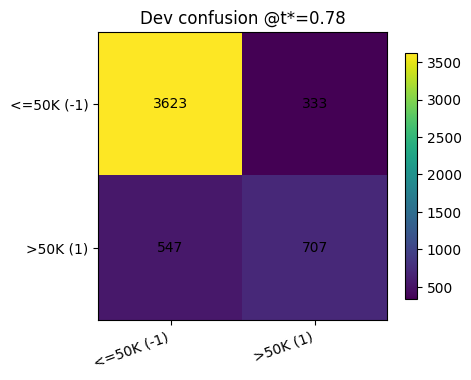

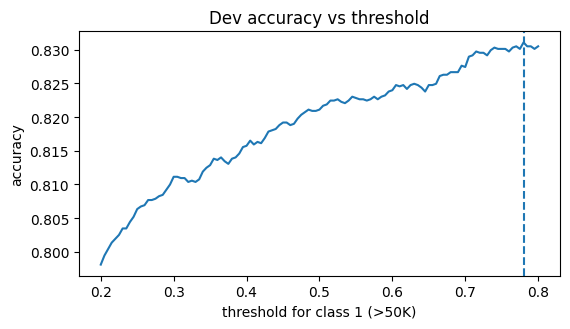

In [28]:
# cell 24 — evaluate the selected model on dev (no file writes)
# uses BEST_PIPELINE (fit on X_tr_bal) and BEST_THR from step c

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# dev predictions
y_va_proba = BEST_PIPELINE.predict_proba(X_va)[:, 1]
y_va_pred05 = (y_va_proba >= 0.50).astype(int) * 2 - 1
y_va_predTS = (y_va_proba >= BEST_THR).astype(int) * 2 - 1

# dev metrics
acc05 = accuracy_score(y_va, y_va_pred05)
accTS = accuracy_score(y_va, y_va_predTS)
cm05  = confusion_matrix(y_va, y_va_pred05, labels=[-1, 1])
cmTS  = confusion_matrix(y_va, y_va_predTS, labels=[-1, 1])
fpr, tpr, _ = roc_curve(y_va, y_va_proba, pos_label=1)
rocA = auc(fpr, tpr)

print({"cv_mean_accuracy": round(best_score,4),
       "dev_acc@0.50": round(acc05,4),
       "dev_acc@t*": round(accTS,4),
       "t*": round(BEST_THR,3),
       "dev_auc": round(rocA,4)})

# visuals (display only)
loss_curve = BEST_PIPELINE.named_steps["clf"].loss_curve_

plt.figure(figsize=(5.6,3.4))
plt.plot(range(1, len(loss_curve)+1), loss_curve, marker="o", linewidth=1)
plt.title("MLP training loss (best config)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.6,3.4))
plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
plt.plot([0,1],[0,1],"--")
plt.title("Dev ROC (best config)")
plt.xlabel("false positive rate"); plt.ylabel("true positive rate")
plt.legend(); plt.tight_layout(); plt.show()

labels = ["<=50K (-1)", ">50K (1)"]
for title, cm in [("confusion @0.50", cm05), (f"confusion @t*={BEST_THR:.2f}", cmTS)]:
    plt.figure(figsize=(4.8,4.0))
    plt.imshow(cm)
    plt.xticks([0,1], labels, rotation=20, ha="right")
    plt.yticks([0,1], labels)
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, int(v), ha="center", va="center")
    plt.title(f"Dev {title}")
    plt.colorbar(shrink=0.8); plt.tight_layout(); plt.show()

thr_grid = np.linspace(0.20, 0.80, 121)
acc_curve = [accuracy_score(y_va, (y_va_proba>=t).astype(int)*2-1) for t in thr_grid]
plt.figure(figsize=(5.8,3.4))
plt.plot(thr_grid, acc_curve); plt.axvline(BEST_THR, ls="--")
plt.title("Dev accuracy vs threshold"); plt.xlabel("threshold for class 1 (>50K)"); plt.ylabel("accuracy")
plt.tight_layout(); plt.show()


In [29]:
# cell 25 — refit on ALL labeled data (train+dev), balanced

from sklearn.base import clone

# combine labeled data
X_all = pd.concat([X_tr, X_va], axis=0)
y_all = pd.concat([y_tr, y_va], axis=0)

# balance with the same upsampling method
X_all_bal, y_all_bal = upsample_minority(X_all, y_all)

# fresh clone and fit
FINAL_PIPELINE = clone(BEST_PIPELINE)
_ = FINAL_PIPELINE.fit(X_all_bal, y_all_bal)

print("final model fitted on full labeled data.")


final model fitted on full labeled data.


In [30]:
# cell 26 — build predictions on provided validation inputs (preview only; no write yet)

proba_hold = FINAL_PIPELINE.predict_proba(df_hold)[:, 1]
pred_hold  = np.where(proba_hold >= BEST_THR, 1, -1).astype(int)

submission = pd.DataFrame({"prediction": pred_hold})
assert set(submission["prediction"].unique()).issubset({-1, 1})
print("submission shape:", submission.shape)
submission.head(10)


submission shape: (6513, 1)


,prediction
0,-1
1,1
2,1
3,-1
4,-1
5,1
6,1
7,-1
8,-1
9,1


In [31]:
# cell 27 — write the ONLY graded deliverable (per rubric)
# output path/name defined earlier as SUBMISSION_PATH

submission.to_csv(SUBMISSION_PATH, index=False)
print("wrote:", SUBMISSION_PATH)


wrote: submission/Group_14_MLP_PredictedOutputs.csv


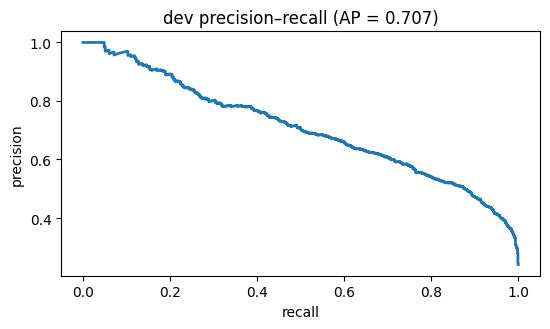

In [32]:
# cell 28 — precision–recall curve on dev (plus average precision)

from sklearn.metrics import precision_recall_curve, average_precision_score

y_va_bin = (y_va == 1).astype(int)
prec, rec, _ = precision_recall_curve(y_va_bin, y_va_proba)
ap = average_precision_score(y_va_bin, y_va_proba)

plt.figure(figsize=(5.6,3.4))
plt.plot(rec, prec, linewidth=2)
plt.title(f"dev precision–recall (AP = {ap:.3f})")
plt.xlabel("recall"); plt.ylabel("precision")
plt.tight_layout(); plt.show()


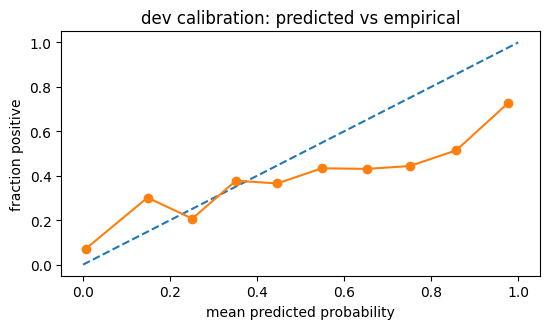

In [33]:
# cell 29 — calibration (reliability) plot on dev (10 equal-width bins)

bins = np.linspace(0.0, 1.0, 11)
idx  = np.digitize(y_va_proba, bins) - 1
cal  = []
for b in range(10):
    mask = idx == b
    if mask.sum() == 0:
        continue
    mean_pred = float(y_va_proba[mask].mean())
    frac_pos  = float((y_va_bin[mask]).mean())
    cal.append((mean_pred, frac_pos))

cal = np.array(cal)
plt.figure(figsize=(5.6,3.4))
plt.plot([0,1],[0,1],"--")
plt.plot(cal[:,0], cal[:,1], marker="o")
plt.title("dev calibration: predicted vs empirical")
plt.xlabel("mean predicted probability"); plt.ylabel("fraction positive")
plt.tight_layout(); plt.show()


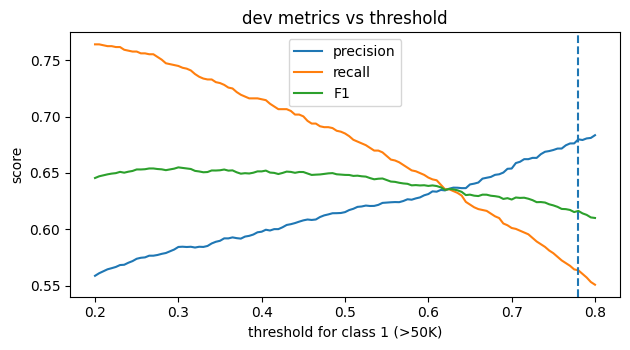

In [34]:
# cell 30 — threshold sweep on dev: precision / recall / F1 (complements accuracy sweep)

thr_grid = np.linspace(0.20, 0.80, 121)
prec_list, rec_list, f1_list = [], [], []
for t in thr_grid:
    pred = (y_va_proba >= t).astype(int)*2 - 1
    tp = ((y_va==1) & (pred==1)).sum()
    fp = ((y_va==-1) & (pred==1)).sum()
    fn = ((y_va==1) & (pred==-1)).sum()
    precision = tp / (tp + fp) if (tp+fp)>0 else 0.0
    recall    = tp / (tp + fn) if (tp+fn)>0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    prec_list.append(precision); rec_list.append(recall); f1_list.append(f1)

plt.figure(figsize=(6.4,3.6))
plt.plot(thr_grid, prec_list, label="precision")
plt.plot(thr_grid, rec_list,  label="recall")
plt.plot(thr_grid, f1_list,   label="F1")
plt.axvline(BEST_THR, linestyle="--")
plt.title("dev metrics vs threshold")
plt.xlabel("threshold for class 1 (>50K)"); plt.ylabel("score")
plt.legend(); plt.tight_layout(); plt.show()


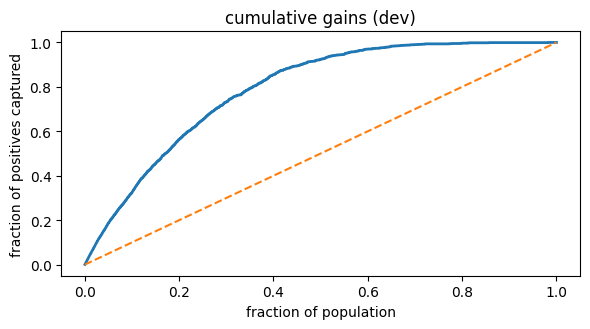

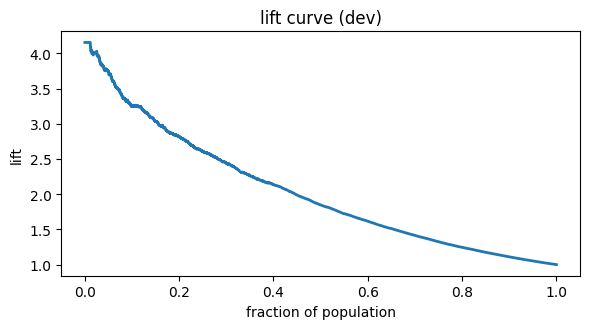

In [35]:
# cell 31 — lift and cumulative gains curves on dev

# sort by score descending
order = np.argsort(-y_va_proba)
y_sorted = y_va_bin.values[order]
scores_sorted = y_va_proba[order]

total_pos = y_sorted.sum()
cum_pos = y_sorted.cumsum()
pop_frac = np.arange(1, len(y_sorted)+1) / len(y_sorted)
gains = cum_pos / total_pos               # cumulative % of positives captured
lift  = gains / pop_frac                  # how many times better than random

# cumulative gains
plt.figure(figsize=(6.0,3.4))
plt.plot(pop_frac, gains, linewidth=2)
plt.plot([0,1],[0,1],"--")
plt.title("cumulative gains (dev)")
plt.xlabel("fraction of population"); plt.ylabel("fraction of positives captured")
plt.tight_layout(); plt.show()

# lift curve
plt.figure(figsize=(6.0,3.4))
plt.plot(pop_frac, lift, linewidth=2)
plt.title("lift curve (dev)")
plt.xlabel("fraction of population"); plt.ylabel("lift")
plt.tight_layout(); plt.show()


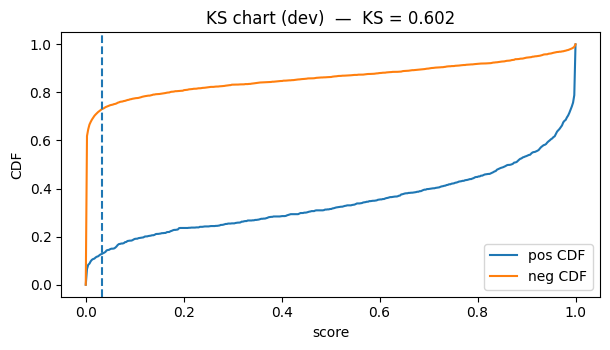

In [36]:
# cell 32 — KS chart (Kolmogorov–Smirnov) on dev

# empirical CDFs of scores for positives and negatives
pos_scores = y_va_proba[y_va==1]
neg_scores = y_va_proba[y_va==-1]
grid = np.linspace(0, 1, 400)
cdf_pos = np.array([(pos_scores <= g).mean() for g in grid])
cdf_neg = np.array([(neg_scores <= g).mean() for g in grid])
ks = np.max(np.abs(cdf_pos - cdf_neg))
ks_x = grid[np.argmax(np.abs(cdf_pos - cdf_neg))]

plt.figure(figsize=(6.2,3.6))
plt.plot(grid, cdf_pos, label="pos CDF")
plt.plot(grid, cdf_neg, label="neg CDF")
plt.axvline(ks_x, linestyle="--")
plt.title(f"KS chart (dev)  —  KS = {ks:.3f}")
plt.xlabel("score"); plt.ylabel("CDF")
plt.legend(); plt.tight_layout(); plt.show()


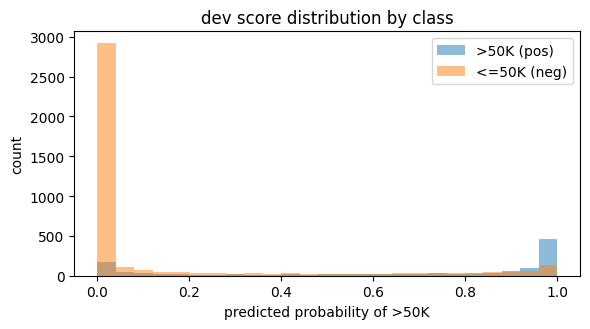

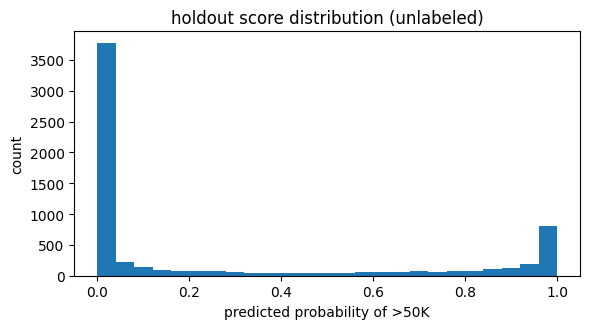

In [37]:
# cell 33 — probability histograms
# dev: class-conditioned; holdout: overall distribution only (no labels available)

# dev overlay
plt.figure(figsize=(6.0,3.4))
plt.hist(pos_scores, bins=25, alpha=0.5, label=">50K (pos)")
plt.hist(neg_scores, bins=25, alpha=0.5, label="<=50K (neg)")
plt.title("dev score distribution by class")
plt.xlabel("predicted probability of >50K"); plt.ylabel("count")
plt.legend(); plt.tight_layout(); plt.show()

# holdout only (from step e)
plt.figure(figsize=(6.0,3.4))
plt.hist(proba_hold, bins=25)
plt.title("holdout score distribution (unlabeled)")
plt.xlabel("predicted probability of >50K"); plt.ylabel("count")
plt.tight_layout(); plt.show()
